# ANALYSIS OF MTOR

This notebook contains an analysis of the mTOR system described in a paper by TM Varusai and LK Nguyen, 2018
(Dynamic modelling of the mTOR signalling network reveals complex emergent behaviours conferred by DEPTOR.
Varusai TM, Nguyen LK
Scientific reports , 1/ 2018 , Volume 8 , Issue 1 , pages: 643 , PubMed ID: 29330362). The SBML model for this system is in Biomodels, ``BIOMD0000000823``.

We consider a model of the signaling network for mTOR, the mechanistic Target of Rapamycin (mTOR), an evolutionarily conserved network that controls key cellular processes, especially cell growth and metabolism. The signalling cascade is activated by a variety of receptor tyrosine kinases, most notably the Insulin Receptor.

<img src="images/mTOR-System.png"
     alt="Markdown Monster icon"
     width="500" height="600"
     style="float: left; margin-right: 10px;" />

In [ ]:
import sys
sys.path.insert(0, '/Users/jlheller/home/Technical/repos/controlSBML/src')

In [2]:
from controlSBML import ControlSBML

import control
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
MTOR_MODEL = """
// Created by libAntimony v2.13.2
function Constant_flux__irreversible(v)
  v;
end

Constant_flux__irreversible is "Constant flux (irreversible)"

function Henri_Michaelis_Menten__irreversible(substrate, Km, V)
  V*substrate/(Km + substrate);
end

Henri_Michaelis_Menten__irreversible is "Henri-Michaelis-Menten (irreversible)"

function HMM_Mod(V, s, m, Km)
  V*s*m/(Km + s);
end

HMM_Mod is "HMM_Mod"

function Function_for_v11(k11ca, pmTORC1, DEPTOR, Km11a, pDEPTOR, k11cb, pmTORC2, Km11b)
  k11ca*pmTORC1*DEPTOR/(Km11a + pDEPTOR) + k11cb*pmTORC2*DEPTOR/(Km11b + DEPTOR);
end

Function_for_v11 is "Function_for_v11"

function Function_for_v5(k5ca, pIRS, Akt, Km5a, k5cb, pmTORC2, Km5b)
  k5ca*pIRS*Akt/(Km5a + Akt) + k5cb*pmTORC2*Akt/(Km5b + Akt);
end

Function_for_v5 is "Function_for_v5"


model *Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR()

  // Compartments and Species:
  compartment compartment_;
  species IR in compartment_, pIR in compartment_, IRS in compartment_, pIRS in compartment_;
  species iIRS in compartment_, Akt in compartment_, pAkt in compartment_;
  species mTORC1 in compartment_, pmTORC1 in compartment_, mTORC2 in compartment_;
  species pmTORC2 in compartment_, imTORC2 in compartment_, mTORC1_DEPTOR in compartment_;
  species mTORC2_DEPTOR in compartment_, DEPTOR in compartment_, pDEPTOR in compartment_;

  // Reactions:
  v1: IR => pIR; compartment_*Henri_Michaelis_Menten__irreversible(IR, Km1, V1);
  v2: pIR => IR; compartment_*Henri_Michaelis_Menten__irreversible(pIR, Km2, V2);
  v3: IRS => pIRS; compartment_*HMM_Mod(k3c, IRS, pIR, Km3);
  v4: pIRS => IRS; compartment_*Henri_Michaelis_Menten__irreversible(pIRS, Km4, V4);
  v5: Akt => pAkt; compartment_*Function_for_v5(k5ca, pIRS, Akt, Km5a, k5cb, pmTORC2, Km5b);
  v6: pAkt => Akt; compartment_*Henri_Michaelis_Menten__irreversible(pAkt, Km6, V6);
  v7: mTORC1 => pmTORC1; compartment_*HMM_Mod(k7c, mTORC1, pAkt, Km7);
  v8: pmTORC1 => mTORC1; compartment_*Henri_Michaelis_Menten__irreversible(pmTORC1, Km8, V8);
  v9: mTORC2 => pmTORC2; compartment_*HMM_Mod(k9c, mTORC2, pIR, Km9);
  v10: pmTORC2 => mTORC2; compartment_*Henri_Michaelis_Menten__irreversible(pmTORC2, Km10, V10);
  v11: DEPTOR => pDEPTOR; compartment_*Function_for_v11(k11ca, pmTORC1, DEPTOR, Km11a, pDEPTOR, k11cb, pmTORC2, Km11b);
  v12: pDEPTOR => DEPTOR; compartment_*Henri_Michaelis_Menten__irreversible(pDEPTOR, Km12, V12);
  v13: mTORC1 + DEPTOR -> mTORC1_DEPTOR; compartment_*(k13f*mTORC1*DEPTOR - k13r*mTORC1_DEPTOR);
  v14: mTORC2 + DEPTOR -> mTORC2_DEPTOR; compartment_*(k14f*mTORC2*DEPTOR - k14r*mTORC2_DEPTOR);
  v15: IRS => iIRS; compartment_*HMM_Mod(k15c, IRS, pmTORC1, Km15);
  v16: iIRS => IRS; compartment_*Henri_Michaelis_Menten__irreversible(iIRS, Km16, V16);
  v17:  => DEPTOR; compartment_*Constant_flux__irreversible(ks17);
  v18: pDEPTOR => ; compartment_*kd18*pDEPTOR;

  // Species initializations:
  IR = 50;
  pIR = 0;
  IRS = 100;
  pIRS = 0;
  iIRS = 0;
  Akt = 100;
  pAkt = 0;
  mTORC1 = 250;
  pmTORC1 = 0;
  mTORC2 = 200;
  pmTORC2 = 0;
  imTORC2 = 0;
  mTORC1_DEPTOR = 0;
  mTORC2_DEPTOR = 0;
  DEPTOR = 350;
  pDEPTOR = 0;

  // Compartment initializations:
  compartment_ = 1;

  // Variable initializations:
  V1 = 1;
  Km1 = 95;
  V2 = 1;
  Km2 = 35;
  k3c = 0.1;
  Km3 = 50;
  V4 = 1;
  Km4 = 50;
  k5ca = 0.05;
  Km5a = 7;
  k5cb = 1.5;
  Km5b = 4;
  V6 = 2;
  Km6 = 34;
  k7c = 0.1;
  Km7 = 2;
  V8 = 6;
  Km8 = 1;
  k9c = 0.3;
  Km9 = 160;
  V10 = 3;
  Km10 = 7;
  k11ca = 0.1;
  Km11a = 120;
  k11cb = 0.13;
  Km11b = 11;
  V12 = 4;
  Km12 = 7;
  k13f = 0.001;
  k13r = 0.006;
  k14f = 0.007;
  k14r = 0.006;
  k15c = 0.1;
  Km15 = 50;
  V16 = 1;
  Km16 = 50;
  ks17 = 0;
  kd18 = 0;

  // Other declarations:
  const compartment_, V1, Km1, V2, Km2, k3c, Km3, V4, Km4, k5ca, Km5a, k5cb;
  const Km5b, V6, Km6, k7c, Km7, V8, Km8, k9c, Km9, V10, Km10, k11ca, Km11a;
  const k11cb, Km11b, V12, Km12, k13f, k13r, k14f, k14r, k15c, Km15, V16;
  const Km16, ks17, kd18;

  // Unit definitions:
  unit volume = 1e-3 litre;
  unit substance = 1e-3 mole;

  // Display Names:
  compartment_ is "compartment";

  // CV terms:
  compartment_ hypernym "http://identifiers.org/ncit/C48694"
  IR identity "http://identifiers.org/pr/PR:000009064"
  pIR hypernym "http://identifiers.org/pr/PR:000009064"
  IRS identity "http://identifiers.org/ncit/C28474"
  pIRS hypernym "http://identifiers.org/ncit/C28474"
  iIRS hypernym "http://identifiers.org/ncit/C28474"
  Akt identity "http://identifiers.org/pr/PR:000029189"
  pAkt hypernym "http://identifiers.org/pr/PR:000029189"
  mTORC1 hypernym "http://identifiers.org/ncit/C96314"
  pmTORC1 hypernym "http://identifiers.org/ncit/C96314"
  mTORC2 identity "http://identifiers.org/ncit/C96315"
  pmTORC2 hypernym "http://identifiers.org/ncit/C96315"
  imTORC2 hypernym "http://identifiers.org/ncit/C96315"
  mTORC1_DEPTOR part "http://identifiers.org/ncit/C96314"
  mTORC1_DEPTOR part "http://identifiers.org/ncit/C101595"
  mTORC2_DEPTOR part "http://identifiers.org/ncit/C101595"
  mTORC2_DEPTOR part "http://identifiers.org/ncit/mTORC2"
  DEPTOR identity "http://identifiers.org/ncit/C101595"
  pDEPTOR hypernym "http://identifiers.org/ncit/C101595"
  v1 hypernym "http://identifiers.org/go/GO:0016310"
  v2 hypernym "http://identifiers.org/go/GO:0016311"
  v3 hypernym "http://identifiers.org/go/GO:0016310"
  v4 hypernym "http://identifiers.org/go/GO:0016311"
  v5 hypernym "http://identifiers.org/go/GO:0016310"
  v6 hypernym "http://identifiers.org/go/GO:0016311"
  v7 hypernym "http://identifiers.org/go/GO:0016310"
  v8 hypernym "http://identifiers.org/go/GO:0016311"
  v9 hypernym "http://identifiers.org/go/GO:0016310"
  v10 hypernym "http://identifiers.org/go/GO:0016311"
  v11 hypernym "http://identifiers.org/go/GO:0016310"
  v12 hypernym "http://identifiers.org/go/GO:0016311"
  v13 hypernym "http://identifiers.org/ncit/C18469"
  v14 hypernym "http://identifiers.org/ncit/C18469"
  v15 hypernym "http://identifiers.org/ncit/C16983"
  v15 hypernym "http://identifiers.org/sbo/SBO:0000169"
  v16 hypernym "http://identifiers.org/ncit/C21018"
  v17 hypernym "http://identifiers.org/ncit/C80450"
  v18 hypernym "http://identifiers.org/ncit/C61559"
end

Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR is "Varusai2018 - Dynamic modelling of the mTOR signalling network reveals complex emergent behaviours conferred by DEPTOR"

Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR description "http://identifiers.org/pubmed/29330362"
Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR model_entity_is "http://identifiers.org/biomodels.db/MODEL1909250003",
                                                                                                                                       "http://identifiers.org/biomodels.db/BIOMD0000000823"
Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR property "http://identifiers.org/mamo/MAMO_0000046"
Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR property "http://identifiers.org/pw/PW:0000180"
Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR property "http://identifiers.org/ncit/C101595"
Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR taxon "http://identifiers.org/taxonomy/9606"
"""

# 1. Problem statement and system definition

## Problem statement

The biological problem we address is controlling the concentration of phosphorylated ``mTORC1``, ``pmTORC1`. This system has complex dynamics, with both oscillations and bistatility. We want to operate in a region that avoids both. Our control objectives are:
* Regulate ``pmTORC1` to a setpoint
* Fast settling times
* Avoid oscillations

## System definition

A system is defined by the following:
1. SBML model
1. output
1. input
1. directional effect of the input on the output
1. operating region for the input
1. range of outputs that can be achieved

We have specified the SBML model and the output in our problem statement. We proceed with (3), the input that regulates ``pmTORC1`` to a setpoint.

By plotting the model we can see the possible species to use as inputs.

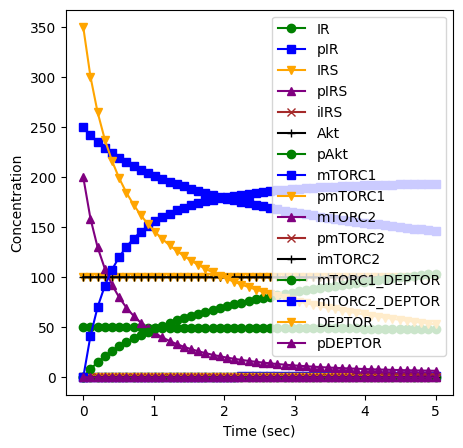

In [4]:
CTLSB = ControlSBML(MTOR_MODEL)
_ = CTLSB.plotModel(figsize=(5,5))

Alternatively, we can use the ControlSBML method ``getPossibleInputs`` to see a list of possible inputs. Note that this includes parameters as well as floating species.

In [5]:
print(CTLSB.getPossibleInputs())

floating_species:	IR, pIR, IRS, pIRS, iIRS, Akt, pAkt, mTORC1, pmTORC1, mTORC2, pmTORC2, imTORC2, mTORC1_DEPTOR, mTORC2_DEPTOR, DEPTOR, pDEPTOR

parameter:	Km1, V1, Km2, V2, k3c, Km3, Km4, V4, k5ca, Km5a, k5cb, Km5b, Km6, V6, k7c, Km7, Km8, V8, k9c, Km9, Km10, V10, k11ca, Km11a, k11cb, Km11b, Km12, V12, k13f, k13r, k14f, k14r, k15c, Km15, Km16, V16, ks17, kd18


Based on this, we decide to try the phosphorylated insulin receptor, ``pIRS``.

In [6]:
INPUT_NAME = "pIRS"
OUTPUT_NAME = "pmTORC1"
CTLSB = ControlSBML(MTOR_MODEL, figsize=(5, 5), times=np.linspace(0, 2000, 20000), markers=False,
                   save_path="data.csv", input_names=[INPUT_NAME], output_names=[OUTPUT_NAME])  # Specify default value of options

We can look at just a subset of the floating specifies by using the output of ``plotModel``.

<Axes: xlabel='miliseconds'>

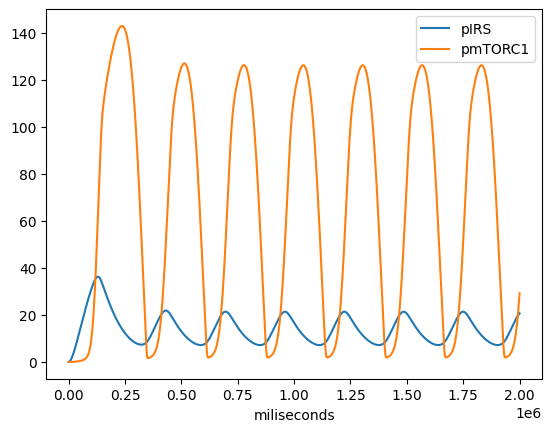

In [7]:
ts = CTLSB.plotModel(is_plot=False)
df = ts[[INPUT_NAME, OUTPUT_NAME]]
seconds = np.array(df.index)/1000
df.index = seconds
df.plot()

The input and output seem to be related. The question is can we *control* the output by varying the input? To anser this question, we construct a *staircase plot*. This plot sets the input to values that are changed during the simulation. We want to see if the output tracks these changes in input.

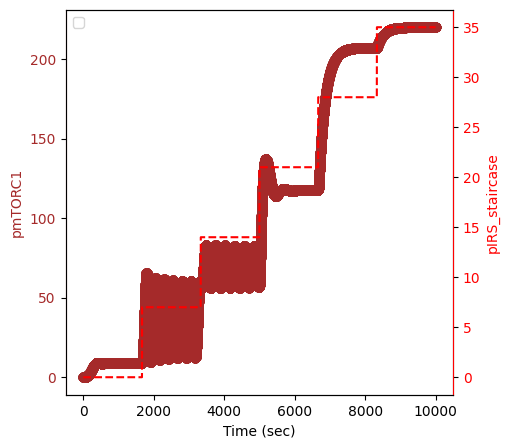

In [8]:
_ = CTLSB.plotStaircaseResponse(initial_value=0, final_value=35, times=np.linspace(0, 10000, 100000))

Clearly, the effect of theinput, pIRS, is effective over only a subset of the range of pIRS. So, we narrow the operating region to [20, 25]. Note that this means the possible setpoints for ``pmTORC1`` are in the interval [135, 180].

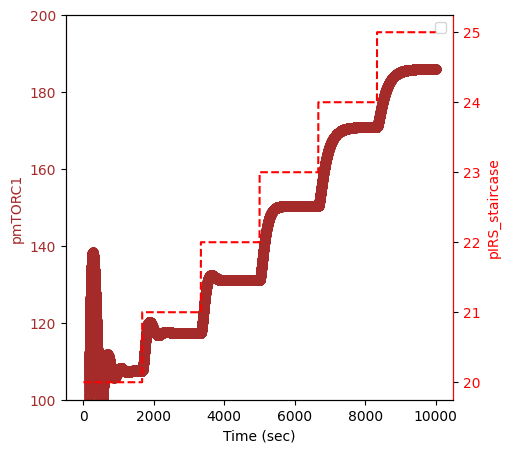

In [9]:
_, builder = CTLSB.plotStaircaseResponse(initial_value=20, final_value=25, times=np.linspace(0, 10000, 100000), ylim=[100, 200])

The initial transient is likely related to initial conditions set by the model. We can ignore this since they disappear after a few hundred seconds.

Below, we provide the complete system definition.

1. SBML model: mTOR model from BioModels
1. output: ``pmTORC1``
1. input: ``pIRS``
1. directional effect of the input on the output: monotone increasing
1. operating region for the input: [20, 25]
1. range of outputs that can be achieved: [120, 200]

# 2. System Identification

System identification describes the system as a transfer function for the operating point specified in system definition. In our system, the input is ``pIRS`` and the output is ``pmTORC1``. ``pIRS`` is varied over the operating region of [20, 25]. The method ``plotTransferFunctionFit`` estimates to transfer function and plots the fit. It returns a Timeseries (a dataframe with the data plotted) and an AntimonyBuilder (the Antimony code run to produce the fitting data).

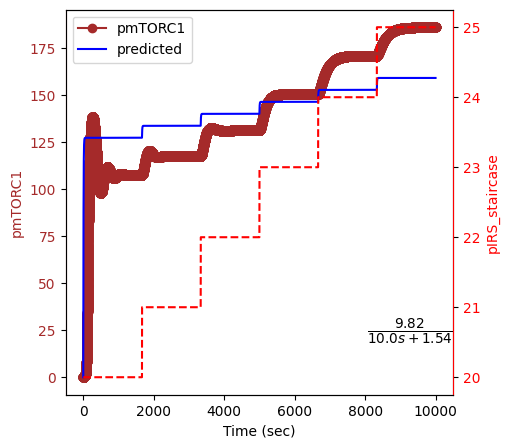

In [10]:
_ = CTLSB.plotTransferFunctionFit(num_numerator=1, num_denominator=2, initial_value=20, final_value=25, 
                                  times=np.linspace(0, 10000, 100000))

This is a pretty rough approximation to the actual output. Part of the problem is the initial transient, which distorts the fit. We can handle this by specifying the times over which the fit is to be done (which, by default, is the entire interval).

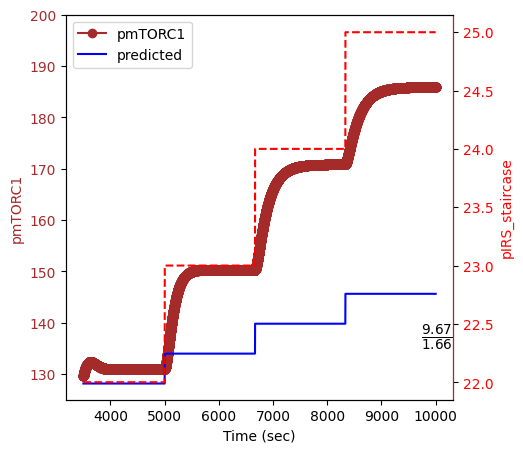

In [11]:
_ = CTLSB.plotTransferFunctionFit(num_numerator=1, num_denominator=2, initial_value=20, final_value=25,
                                  fit_start_time=3500, times=np.linspace(0, 10000, 100000), ylim=[125, 200])

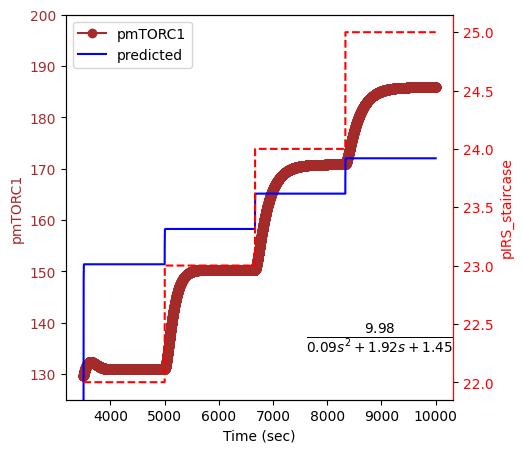

In [12]:
_ = CTLSB.plotTransferFunctionFit(num_numerator=1, num_denominator=3, initial_value=20, final_value=25,
                                  fit_start_time=3500, times=np.linspace(0, 10000, 100000), ylim=[125, 200])

In [13]:
CTLSB.getOpenLoopTransferFunction().poles()

array([-19.99801648+0.j,  -0.78455464+0.j])

This didn't help. So, lets add two more pole and a zero to the transfer function, and restrict the y-values to the output range in our system definition. Since controlSBML must estimate more poles and zeroes, it takes longer.

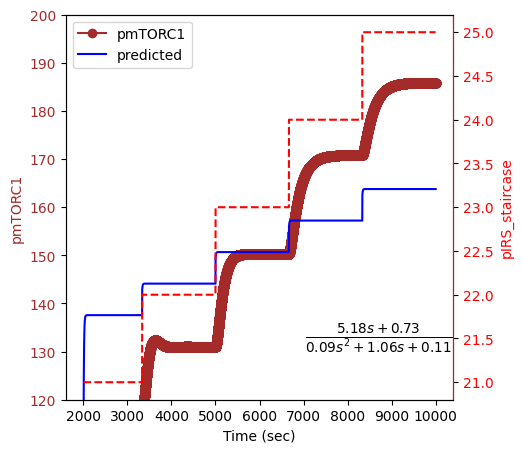

In [14]:
_ = CTLSB.plotTransferFunctionFit(num_numerator=2, num_denominator=3, initial_value=20, final_value=25,
                                  fit_start_time=2000, times=np.linspace(0, 10000, 100000),  ylim=[120, 200])

In [15]:
CTLSB.getOpenLoopTransferFunction().poles(), CTLSB.getOpenLoopTransferFunction().zeros()

(array([-12.07230933+0.j,  -0.10616191+0.j]), array([-0.14066354+0.j]))

The zero is fairly small, and so we can simplify the transfer function a bit.

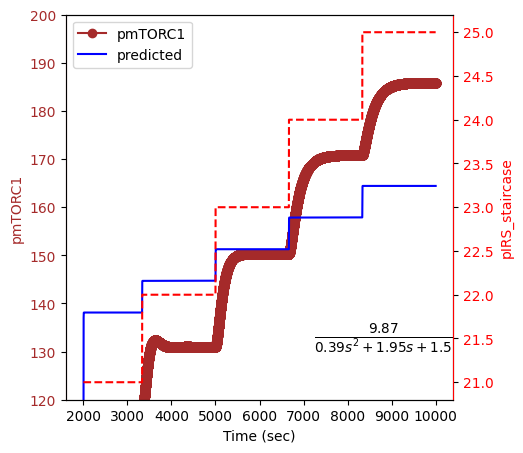

In [16]:
_ = CTLSB.plotTransferFunctionFit(num_numerator=1, num_denominator=3, initial_value=20, final_value=25,
                                  fit_start_time=2000, times=np.linspace(0, 10000, 100000),  ylim=[120, 200])

This is not a great fit, but the directional effects are reasonable.

The plot displays the transfer function of the fit. We can also obtain the transfer function object. We see that both poles are real and negative. However, one poles is fairly close to 0, and so there will be long settling times.

In [17]:
TRANSFER_FUNCTION = CTLSB.getOpenLoopTransferFunction()
TRANSFER_FUNCTION

TransferFunction(array([9.8661062]), array([0.3890206 , 1.94888143, 1.50007919]))

In [18]:
TRANSFER_FUNCTION.poles(), TRANSFER_FUNCTION.zeros()

(array([-4.05993342+0.j, -0.94977925+0.j]), array([], dtype=complex128))

# 3. Control design


## Testbed construction

Here, we build a closed loop system where the open loop is the SBML model of the simulated system. Our has a PI controller.

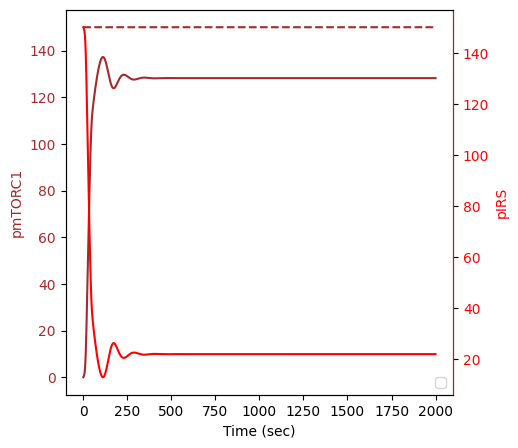

In [19]:
_, builder = CTLSB.plotClosedLoop(setpoint=150, kP=1, kF=None)

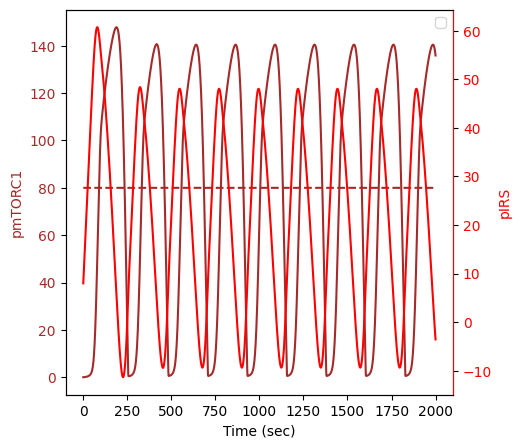

In [20]:
_ = CTLSB.plotClosedLoop(setpoint=80, kP=0.1, kI=0.01, kF=None)

We are able to simulate the closed loop system, but it's not easy to find design parameters that meet our control objectives.

## Closed Loop Design

Here we introduce capabilities of ``controlSBML`` that aid in design

One approach is to use design techniques for linear time-invariant (LTI) systems, such as root locus plots or frequency methods. Since we have a transfer function for the open loop system (obtained when we did System Identification), these techniques are available to us via the rich capabilities of the Python Control Systems Library.

The root locus plot shows how poles of the closed loop system change when using proportional control. From system identification, we know that the transfer function is

In [21]:
TRANSFER_FUNCTION

TransferFunction(array([9.8661062]), array([0.3890206 , 1.94888143, 1.50007919]))

The zeros and poles are shown below. Note that the zero is very close to one pole, and so we essentially have pole-zero cancelation.

In [22]:
TRANSFER_FUNCTION.zeros(), TRANSFER_FUNCTION.poles()

(array([], dtype=complex128), array([-4.05993342+0.j, -0.94977925+0.j]))

The root locus plot shows the position of poles as $k_P$ goes from zero to $\infty$. Closed loop poles start at an open loop pole with $k_P = 0$.
As $k_P$ gets larger, closed loop poles moved to closed loop zeros, which may be at infinity (as is the case for the "branch" from the smaller pole).

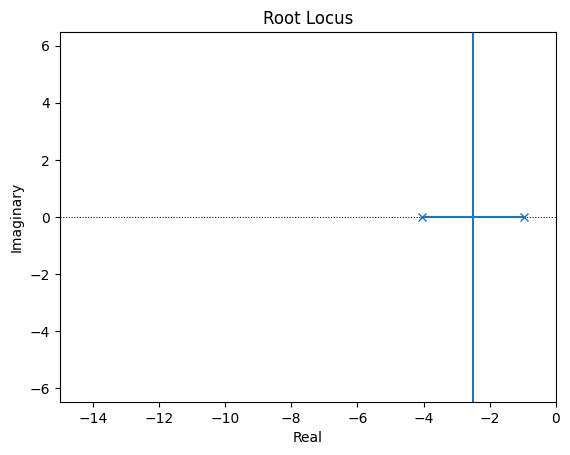

In [23]:
_ = control.rlocus(TRANSFER_FUNCTION, xlim=[-15, 0], grid=False)

The root locus plot indicates that the identified transfer function is stable and should not oscillate (since all poles are real) when considered in a closed loop system, even for large $k_P$. However, we emphasize that this is only an approximation to the nonlinear ``mTOR`` system. As shown below, $k_P$, we see substantial oscillations. The system becomes unstable if $k_P > 3$.

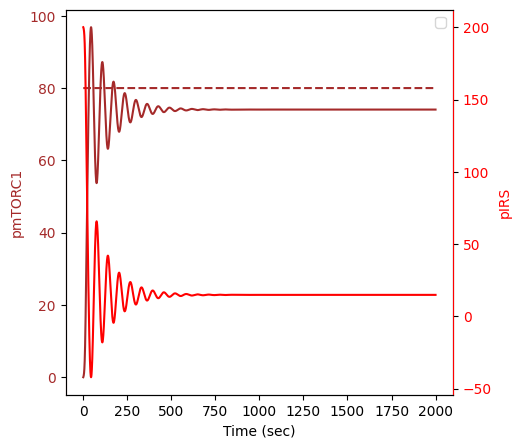

In [24]:
_ = CTLSB.plotClosedLoop(setpoint=80, kP=2.5)

To address the shortcomings of linear approximation,
``controlSBML`` provides a grid search to help in these circumstances. A grid search is a search in an n-dimensional space where each point in the space is a candidate to evaluate. In our case, a candidate is a possible design of the closed loop system. The design is specified by values of $k_P$, $k_I$, and/or $k_F$. The possible values of each parameter are points along an axis in the grid. Selecting one value from each grid defines a point in the design space. ``controlSBML`` searches all points in the grid space and returns one that produces a time course that is closest to the setpoint.

100%|██████████| 100/100 [00:25<00:00,  3.85it/s]


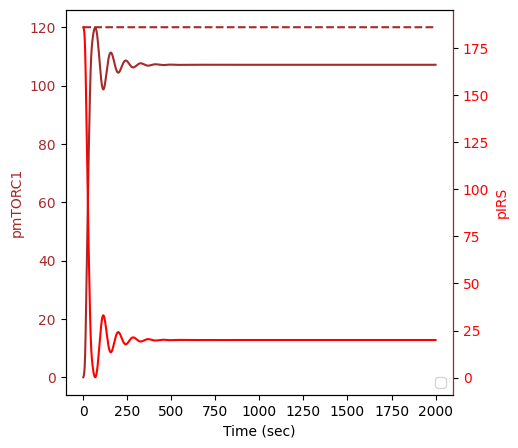

In [25]:
#
# Grid search for a proportional controller
#
# Get the grid when there is only one parameter. There will be 100 values on the axis. Values are evenly spaced (is_random=False).
grid = CTLSB.getGrid(kP_spec=True, kI_spec=False, num_coordinate=100, is_random=False)
axis = grid.getAxis("kP")
# Specify the smallest value on the axis
axis.setMinValue(0.1)
# Specify the highest value on the axis
axis.setMaxValue(10)
# Search. Save the search results in "data1.csv"
ts, builder = CTLSB.plotGridDesign(grid, setpoint=120, save_path="data1.csv")

``controlSBML`` does this search in parallel and provides a progress bar. The degree of parallelism depends on the number of cores available.

The above plot displays the "best"" design in that it has the smallest mean-square-error (MSE) with respect to the setpoint, and there are no negative concentrations. We can see all feasible designs (e.g., excluding those that are unstable) by plotting the design result.

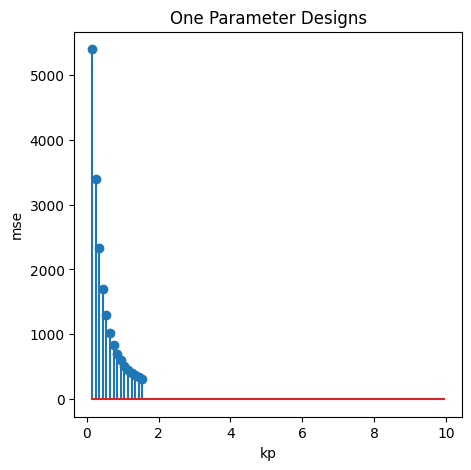

In [26]:
CTLSB.plotDesignResult(figsize=(5,5), title="One Parameter Designs", save_path="data1.csv")

We now explore designs for PI controllers.

100%|██████████| 100/100 [00:27<00:00,  3.70it/s]


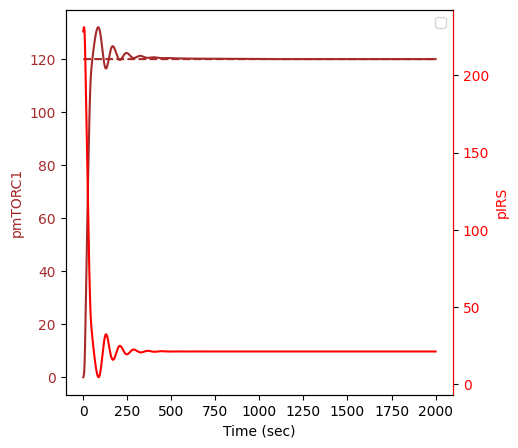

In [27]:
grid = CTLSB.getGrid(kP_spec=True, kI_spec=True, num_coordinate=11, is_random=False)
axis = grid.getAxis("kP")
axis.setMinValue(0.1)
axis.setMaxValue(2)
axis = grid.getAxis("kI")
axis.setMinValue(0.01)
axis.setMaxValue(0.02)
ts, builder = CTLSB.plotGridDesign(grid, setpoint=120, save_path="data2.csv")

Since we have two design parameters, we visualize the results of the grid search using a heatmap where the color of the cell represents its mean squared error.

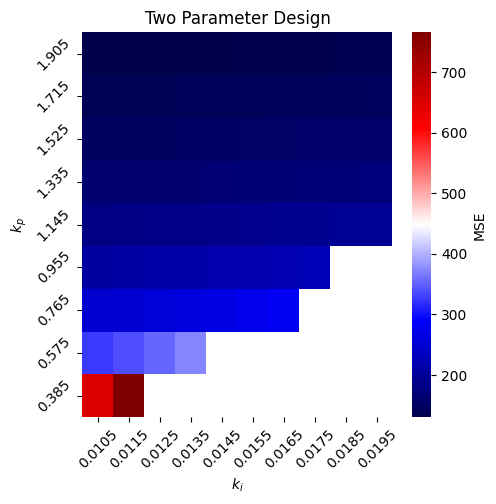

In [28]:
CTLSB.plotDesignResult(figsize=(5,5), save_path="data2.csv", title="Two Parameter Design")

Below is an illustration of a design that is a PI controller with a filter. Note that the number of points in the design space grows multiplicatively with the number of design parameter.

  6%|▌         | 61/1000 [00:18<04:16,  3.66it/s]Error: CVODE Error: CV_TOO_MUCH_WORK, Module: CVODES, Function: CVode, Message: At t = 1853.31, mxstep steps taken before reaching tout.
Error: CVODE Error: CV_TOO_MUCH_WORK, Module: CVODES, Function: CVode, Message: At t = 1941.69, mxstep steps taken before reaching tout.
Error: CVODE Error: CV_TOO_MUCH_WORK, Module: CVODES, Function: CVode, Message: At t = 1831.34, mxstep steps taken before reaching tout.
100%|██████████| 1000/1000 [04:51<00:00,  3.43it/s]
Error: CVODE Error: CV_TOO_MUCH_WORK, Module: CVODES, Function: CVode, Message: At t = 1944.29, mxstep steps taken before reaching tout.


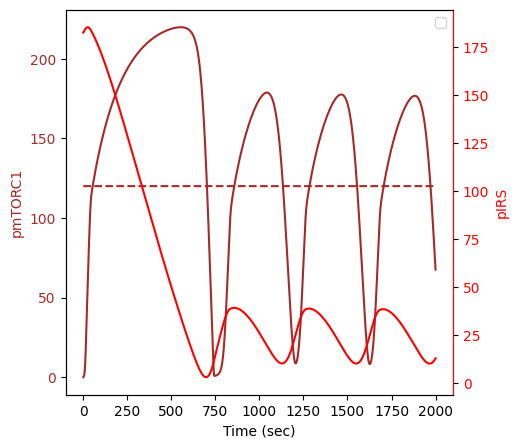

In [29]:
grid = CTLSB.getGrid(kP_spec=True, kI_spec=True, kF_spec=True, num_coordinate=11, is_random=False)
axis = grid.getAxis("kP")
axis.setMinValue(1.5)
axis.setMaxValue(1.9)
axis.setNumCoordinate(11)
axis = grid.getAxis("kI")
axis.setMinValue(0.001)
axis.setMaxValue(0.009)
axis.setNumCoordinate(11)
axis = grid.getAxis("kF")
axis.setMinValue(0.001)
axis.setMaxValue(0.002)
axis.setNumCoordinate(11)
ts, builder = CTLSB.plotGridDesign(grid, setpoint=120, num_restart=1, is_greedy=False,
                                   save_path="data3.csv")

The resulting design is not as good as the PI controller. This is reflected in the MSE values being about ten times larger than those for the PI design without a filter.

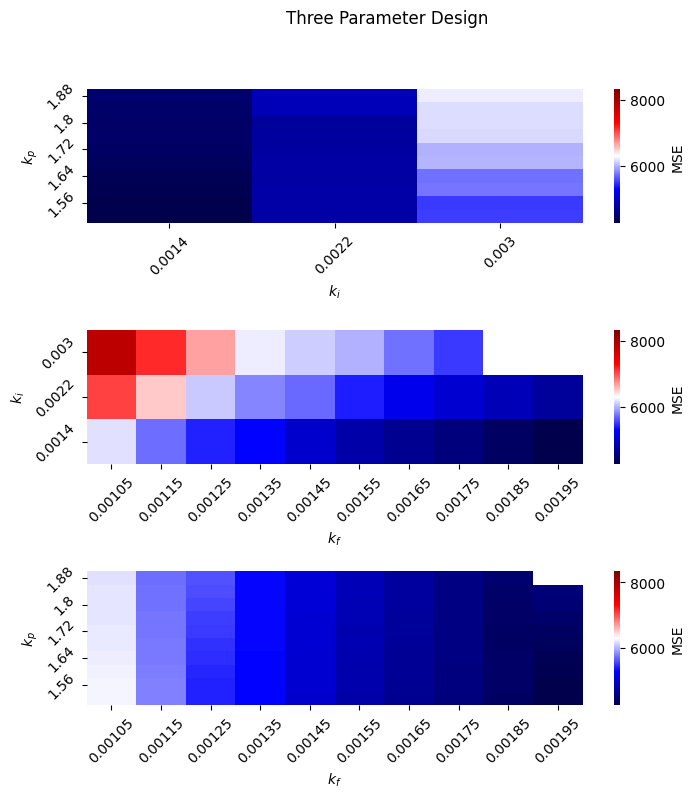

In [30]:
CTLSB.plotDesignResult(save_path="data3.csv", suptitle="Three Parameter Design", figsize=(8,8))